In [2]:
from datetime import datetime, date
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import re
import functools
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer


In [28]:
df = pd.read_csv('weather.csv')

df


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [29]:
df = pd.read_csv('weather.csv').dropna(subset=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']).reset_index(drop=True)

date = {value: datetime.strptime(value, '%Y-%m-%d').timetuple().tm_yday for value in df['Date'].unique()}
location = {value: index for index, value in enumerate(df['Location'].unique())}
wind_direction_max = {value: index for index, value in enumerate(df['WindGustDir'].unique())}
wind_direction_9am = {value: index for index, value in enumerate(df['WindDir9am'].unique())}
wind_direction_3pm = {value: index for index, value in enumerate(df['WindDir3pm'].unique())}

df['Date'] = df['Date'].map(lambda value: date[value])
df['Location'] = df['Location'].map(lambda value: location[value])
df['WindGustDir'] = df['WindGustDir'].map(lambda value: wind_direction_max[value])
df['WindDir9am'] = df['WindDir9am'].map(lambda value: wind_direction_9am[value])
df['WindDir3pm'] = df['WindDir3pm'].map(lambda value: wind_direction_3pm[value])
df['RainToday'] = df['RainToday'].map(lambda value: 0 if value == 'No' else 1)
df['RainTomorrow'] = df['RainTomorrow'].map(lambda value: 0 if value == 'No' else 1)

df.fillna(df.mean(), inplace = True)

df


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,336,0,13.4,22.9,0.6,5.609501,7.718384,0,44.0,0,...,71.0,22.0,1007.7,1007.1,8.000000,4.491408,16.9,21.8,0,0
1,337,0,7.4,25.1,0.0,5.609501,7.718384,1,44.0,1,...,44.0,25.0,1010.6,1007.8,4.407404,4.491408,17.2,24.3,0,0
2,338,0,12.9,25.7,0.0,5.609501,7.718384,2,46.0,0,...,38.0,30.0,1007.6,1008.7,4.407404,2.000000,21.0,23.2,0,0
3,339,0,9.2,28.0,0.0,5.609501,7.718384,3,24.0,2,...,45.0,16.0,1017.6,1012.8,4.407404,4.491408,18.1,26.5,0,0
4,340,0,17.5,32.3,1.0,5.609501,7.718384,0,41.0,3,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123705,171,46,3.5,21.8,0.0,5.609501,7.718384,14,31.0,11,...,59.0,27.0,1024.7,1021.2,4.407404,4.491408,9.4,20.9,0,0
123706,172,46,2.8,23.4,0.0,5.609501,7.718384,14,31.0,2,...,51.0,24.0,1024.6,1020.3,4.407404,4.491408,10.1,22.4,0,0
123707,173,46,3.6,25.3,0.0,5.609501,7.718384,4,22.0,2,...,56.0,21.0,1023.5,1019.1,4.407404,4.491408,10.9,24.5,0,0
123708,174,46,5.4,26.9,0.0,5.609501,7.718384,5,37.0,2,...,53.0,24.0,1021.0,1016.8,4.407404,4.491408,12.5,26.1,0,0


In [30]:
correlation = df.corr()

target_correlation = correlation['RainTomorrow'].sort_values(ascending = False)
target_columns = [target_correlation.index[i] for i, value in filter(lambda item: item[1] > 0, enumerate(target_correlation.values))]\

x = df[target_columns]
y = x.pop('RainTomorrow')

x = StandardScaler().fit_transform(x)


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)


In [32]:
model = keras.Sequential([
	layers.Dense(units=128, activation='relu'),
	layers.Dense(units=128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])


In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [34]:
history = model.fit(x_train, y_train, epochs = 15, batch_size=128, validation_split=0.33)


Epoch 1/15


c:\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


486/486 [==============================] - 1s 1ms/step - loss: 0.3723 - accuracy: 0.8397 - val_loss: 0.3624 - val_accuracy: 0.8443
Epoch 2/15
486/486 [==============================] - 1s 1ms/step - loss: 0.3578 - accuracy: 0.8472 - val_loss: 0.3560 - val_accuracy: 0.8486
Epoch 3/15
486/486 [==============================] - 1s 1ms/step - loss: 0.3553 - accuracy: 0.8483 - val_loss: 0.3539 - val_accuracy: 0.8501
Epoch 4/15
486/486 [==============================] - 1s 1ms/step - loss: 0.3537 - accuracy: 0.8488 - val_loss: 0.3549 - val_accuracy: 0.8485
Epoch 5/15
486/486 [==============================] - 1s 1ms/step - loss: 0.3517 - accuracy: 0.8491 - val_loss: 0.3536 - val_accuracy: 0.8499
Epoch 6/15
486/486 [==============================] - 1s 1ms/step - loss: 0.3511 - accuracy: 0.8497 - val_loss: 0.3548 - val_accuracy: 0.8493
Epoch 7/15
486/486 [==============================] - 1s 1ms/step - loss: 0.3494 - accuracy: 0.8512 - val_loss: 0.3547 - val_accuracy: 0.8486
Epoch 8/15
486/48

In [19]:
def plot_accuracy_loss(history):
	fig = plt.figure(figsize = (10, 5))

	plt.subplot(221)
	plt.plot(history.history['accuracy'], 'bo--', label = 'Training accuracy')
	plt.plot(history.history['val_accuracy'], 'ro--', label = 'Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend(['Training accuracy', 'Validation accuracy'])
	plt.xlabel('Epoch Number')
	plt.ylabel('Accuracy')

	plt.subplot(222)
	plt.plot(history.history['loss'], 'bo--', label = 'Training loss')
	plt.plot(history.history['val_loss'], 'ro--', label = 'Validation loss')
	plt.title('Training and validation losses')
	plt.legend(['Training loss', 'Validation loss'])
	plt.xlabel('Epoch Number')
	plt.ylabel('Loss')

	plt.show()


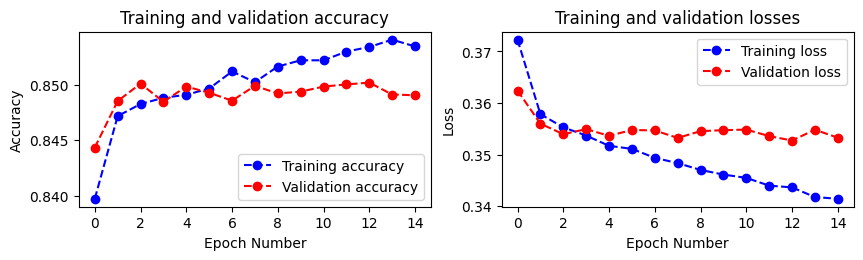

In [36]:
plot_accuracy_loss(history)

In [37]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f'Accuracy score: {accuracy}')

967/967 [==============================] - 1s 528us/step - loss: 0.3500 - accuracy: 0.8504
Accuracy score: 0.8503621220588684


In [7]:
# dataset with animals: https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

image_size = (180, 180)
batch_size = 32

data = keras.utils.image_dataset_from_directory(
    'images/train',
	seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

class_names = data.class_names
class_names

Found 2400 files belonging to 3 classes.


['cats', 'dogs', 'panda']

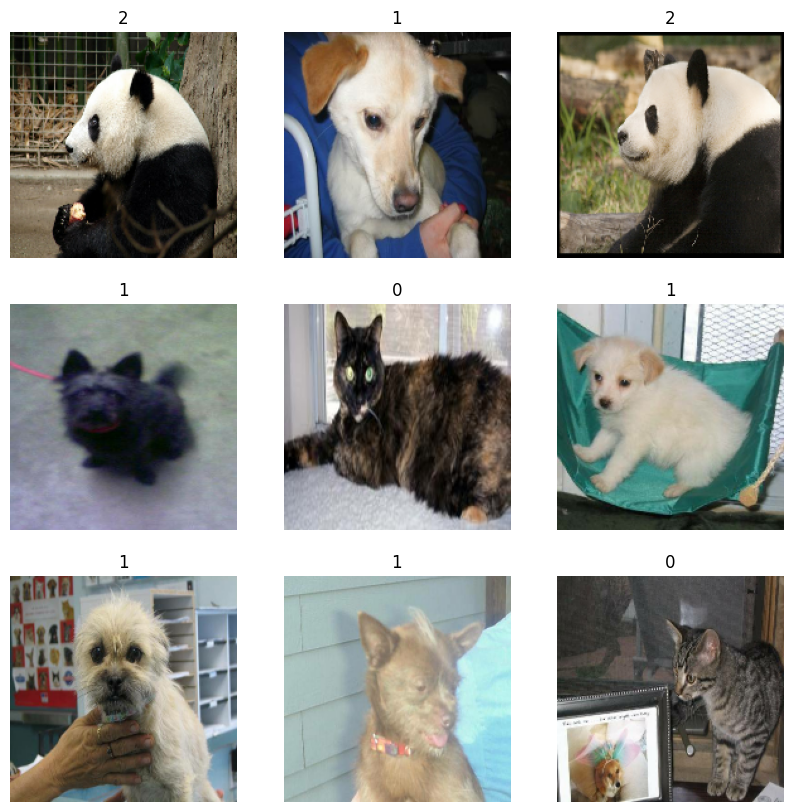

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [24]:
train_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
	'images/train',
	target_size=image_size,
	batch_size=batch_size,
	class_mode='binary'
)

validation_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
	'images/validation',
	target_size=image_size,
	batch_size=batch_size,
	class_mode='binary'
)

test_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
	'images/test',
	target_size=image_size,
	batch_size=batch_size,
	class_mode='binary'
)

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [16]:
num_classes = len(class_names)

model = keras.Sequential([
	layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=image_size + (3,)),
	layers.BatchNormalization(),
	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.BatchNormalization(),
	layers.MaxPooling2D(),
	layers.Dropout(0.2),
	layers.Flatten(),
    layers.Dense(16, activation='relu'),
	layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
	layers.Dense(num_classes, activation="softmax")
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                      

In [17]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    train_generator,
	validation_data=validation_generator,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/25
75/75 [==============================] - 99s 1s/step - loss: 0.8910 - accuracy: 0.5708 - val_loss: 1.0205 - val_accuracy: 0.5133
Epoch 2/25
75/75 [==============================] - 96s 1s/step - loss: 0.6379 - accuracy: 0.7138 - val_loss: 0.9915 - val_accuracy: 0.4567
Epoch 3/25
75/75 [==============================] - 97s 1s/step - loss: 0.4954 - accuracy: 0.7921 - val_loss: 0.8781 - val_accuracy: 0.6000
Epoch 4/25
75/75 [==============================] - 97s 1s/step - loss: 0.3590 - accuracy: 0.8708 - val_loss: 1.0129 - val_accuracy: 0.4433
Epoch 5/25
75/75 [==============================] - 97s 1s/step - loss: 0.2020 - accuracy: 0.9400 - val_loss: 0.9566 - val_accuracy: 0.5367
Epoch 6/25
75/75 [==============================] - 109s 1s/step - loss: 0.1081 - accuracy: 0.9683 - val_loss: 0.8714 - val_accuracy: 0.6233
Epoch 7/25
75/75 [==============================] - 91s 1s/step - loss: 0.0586 - accuracy: 0.9921 - val_loss: 0.7245 - val_accuracy: 0.6800
Epoch 8/25
75/75 [=

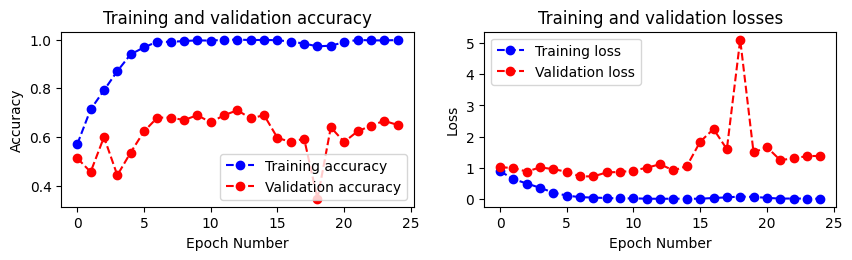

In [20]:
plot_accuracy_loss(history)

In [25]:
loss, accuracy = model.evaluate(test_generator)

print(f'Accuracy score: {accuracy}')

10/10 [==============================] - 2s 209ms/step - loss: 1.0405 - accuracy: 0.7100
Accuracy score: 0.7099999785423279


In [26]:
# source of dataset: https://www.kaggle.com/datasets/algord/fake-news
df = pd.read_csv('./fake-news.csv').dropna().reset_index(drop = True)

print(df['real'].value_counts())

df

1    17371
0     5495
Name: real, dtype: int64


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
22861,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
22862,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
22863,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
22864,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [27]:
stop_words = set(stopwords.words('english'))

def clean_message(message):
	cleaned_message = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|http.+?', '', message.lower())

	return functools.reduce(lambda acc, word: f'{acc} {word}' if word not in stop_words else acc, cleaned_message.split(' '))


In [28]:
df['title'] = df['title'].map(clean_message)

df

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation real ho...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,peoples choice awards 2018 best red carpet looks,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message one t...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma sparks rumours inappro...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl 10 years later upper east siders s...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
22861,pippa middleton wedding case missed itpippa ma...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
22862,zayn malik gigi hadids shocking split theres ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
22863,jessica chastain recalls moment mothers boyfri...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
22864,tristan thompson feels dumped khlo kardashian ...,www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [29]:
x = df['title']
y = df['real']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


In [57]:
max_features = 5000
sequence_length = 100

vectorize_layer = layers.TextVectorization(max_tokens=max_features, output_mode="int", output_sequence_length=sequence_length)
vectorize_layer.adapt(x_train)

model = keras.Sequential([
	layers.Input(shape=(1,), dtype="string"),
	vectorize_layer,
    layers.Embedding(max_features + 1, 128),
	layers.LSTM(64),
	layers.Flatten(),
    layers.Dense(64, activation="relu"),
	layers.Dense(1, activation="sigmoid")
])

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 100, 128)          640128    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                     

In [58]:
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(patience=3),
]

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train, y_train, validation_split=0.2,epochs=epochs, callbacks=callbacks)

Epoch 1/10


C:\Users\o.halitsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


429/429 [==============================] - 19s 41ms/step - loss: 0.5537 - accuracy: 0.7616 - val_loss: 0.5583 - val_accuracy: 0.7539
Epoch 2/10
429/429 [==============================] - 18s 42ms/step - loss: 0.5502 - accuracy: 0.7616 - val_loss: 0.5595 - val_accuracy: 0.7539
Epoch 3/10
429/429 [==============================] - 19s 44ms/step - loss: 0.5500 - accuracy: 0.7616 - val_loss: 0.5582 - val_accuracy: 0.7539
Epoch 4/10
429/429 [==============================] - 19s 44ms/step - loss: 0.5500 - accuracy: 0.7616 - val_loss: 0.5598 - val_accuracy: 0.7539
Epoch 5/10
429/429 [==============================] - 19s 45ms/step - loss: 0.5503 - accuracy: 0.7616 - val_loss: 0.5592 - val_accuracy: 0.7539
Epoch 6/10
429/429 [==============================] - 19s 45ms/step - loss: 0.5501 - accuracy: 0.7616 - val_loss: 0.5595 - val_accuracy: 0.7539


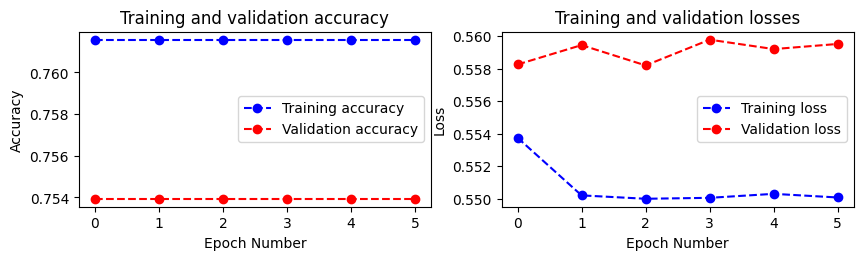

In [59]:
plot_accuracy_loss(history)


In [60]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f'Accuracy score: {accuracy}')

179/179 [==============================] - 2s 12ms/step - loss: 0.5537 - accuracy: 0.7586
Accuracy score: 0.7586146593093872
